In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

### Using saas.csv or log data from API usage or store_item_sales

#### 1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [2]:
# acquire data
df = pd.read_csv('saas.csv')

In [8]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [8]:
df.Customer_Id.value_counts(dropna=False)

1001961    48
1002633    48
1000849    48
1009804    48
1004947    48
           ..
1006518     1
1011305     1
1029101     1
1024220     1
1029304     1
Name: Customer_Id, Length: 29400, dtype: int64

In [7]:
df.Invoice_Id.value_counts(dropna=False)

5244927    1
5504213    1
5082395    1
5080346    1
5086489    1
          ..
5425932    1
5436171    1
5438218    1
5432073    1
5242880    1
Name: Invoice_Id, Length: 790458, dtype: int64

In [10]:
df.Month_Invoiced.value_counts()

2014-01-31    20000
2014-02-28    19800
2014-03-31    19599
2014-04-30    19413
2014-05-31    19221
2014-06-30    19038
2014-07-31    18851
2014-08-31    18672
2014-09-30    18494
2014-10-31    18313
2014-11-30    18145
2014-12-31    17996
2015-01-31    17829
2015-02-28    17680
2015-03-31    17530
2015-04-30    17376
2015-05-31    17225
2015-06-30    17089
2015-07-31    16951
2015-08-31    16817
2015-09-30    16671
2015-10-31    16529
2015-11-30    16387
2015-12-31    16268
2016-01-31    16142
2016-02-29    16019
2016-03-31    15895
2016-04-30    15777
2016-05-31    15685
2016-06-30    15571
2016-07-31    15460
2016-08-31    15355
2016-09-30    15240
2016-10-31    15144
2016-11-30    15049
2016-12-31    14938
2017-01-31    14840
2017-02-28    14741
2017-03-31    14665
2017-04-30    14576
2017-05-31    14475
2017-06-30    14400
2017-07-31    14312
2017-08-31    14209
2017-09-30    14131
2017-10-31    14041
2017-11-30    13985
2017-12-31    13914
Name: Month_Invoiced, dtype: int64

In [9]:
df.Subscription_Type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: Subscription_Type, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


#### To Do to Prep

- Month_Invoiced to datetime
- sort values by date
- set index
- resample monthly (The original granularity is monthly, but there are multiple records of the same months across multiple invoices.)

In [3]:
# data prep function 

def prep_data(df):
    '''
    The function takes in a dataframe and returns a dataframe with 
    the dates as index, aggregated by summing at the monthly level
    '''
    # convert Month_Invoiced to datetime format
    df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
    
    # sort values by date
    df = df.sort_values('Month_Invoiced')
    
    # set index
    df = df.set_index('Month_Invoiced')

    # add month column to df
    df['month'] = df.index.month

    # add day column to df
    df['day_of_week'] = df.index.day_name()
    
    # aggregate or resample daily by summing amount
    df_resampled = df.resample('M')['Amount'].sum()

    return df_resampled

In [4]:
df = prep_data(df)


In [5]:
df.head()


Month_Invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: Amount, dtype: float64

#### Split df

In [6]:
# set train size to be 50% of total 
train_size = int(len(df) * 0.5)
train_size

24

In [7]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size


14

In [8]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

10

In [9]:
# validate will go from 24 to 24+14
validate_end_index = train_size + validate_size
validate_end_index


38

- Use the above values to split the df

In [10]:
# train will go from 0 to 24
train = df[:train_size]
# validate will go from 24 to 38
validate = df[train_size:validate_end_index]
# test will include 38 to the end
test = df[validate_end_index:]

#### Verify Splits

Does the length of each df equate to the length of the original df?

In [11]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


Does the first row of original df equate to the first row of train?



In [12]:
print(df.head(1) == train.head(1))


Month_Invoiced
2014-01-31    True
Freq: M, Name: Amount, dtype: bool


Is the last row of train the month before the first row of validate? And the same for validate to test?



In [13]:
pd.concat([train.tail(1), validate.head(1)])


Month_Invoiced
2015-12-31    51505.0
2016-01-31    51955.0
Freq: M, Name: Amount, dtype: float64

In [14]:
pd.concat([validate.tail(1), test.head(1)])


Month_Invoiced
2017-02-28    53440.0
2017-03-31    53480.0
Freq: M, Name: Amount, dtype: float64

Is the last row of test the same as the last row of our original dataframe?



In [15]:
pd.concat([test.tail(1), df.tail(1)])


Month_Invoiced
2017-12-31    53805.0
2017-12-31    53805.0
Name: Amount, dtype: float64

Let's plot our data first, viewing where the data is split into train and test.



In [18]:
train = pd.DataFrame(data=train)

In [22]:
validate = pd.DataFrame(data=validate)
test = pd.DataFrame(data=test)

In [20]:
train.columns

Index(['Amount'], dtype='object')

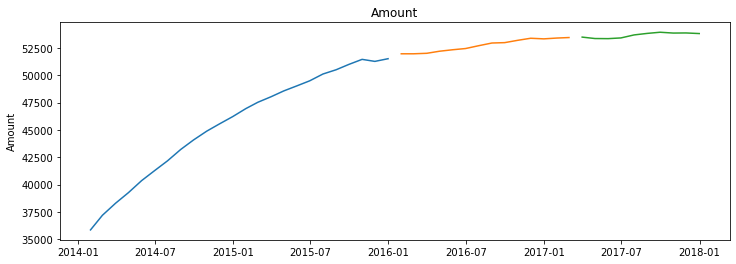

In [23]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.
